# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [9]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [10]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# Option B: Upload your own CSV (uncomment to use in Colab)
#from google.colab import files
#up = files.upload()  # pick file
#import io
#df = pd.read_csv("multimodal_validate.tsv",sep="\t")
#print("Shape:", df.shape)
#df.head()

Saving multimodal_validate.tsv to multimodal_validate.tsv
Shape: (59342, 16)


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,singingdart7854,my xbox controller says hi,1.567436e+09,i.redd.it,True,cypw96,https://preview.redd.it/l0ga0tug17k31.jpg?widt...,NaN,4.0,25,mildlyinteresting,My Xbox controller says hi,0.72,1,0,0
1,mandal0re,new image from the mandalorian,1.567745e+09,i.imgur.com,True,d0bzlq,https://external-preview.redd.it/VX7bXDu9Gl8UZ...,NaN,5.0,21,photoshopbattles,PsBattle: New image from The Mandalorian,0.92,1,0,0
2,HE_WHO_DRUELS,say hello to my little friend,1.461468e+09,NaN,True,d2ezoob,http://i.imgur.com/F1Zbl3D.jpg,4g6bp9,NaN,10,psbattle_artwork,Say hello to my little friend!,NaN,0,2,4
3,eNaRDe,watch your step little one,1.408047e+09,NaN,True,cjqctpw,http://i.imgur.com/KRyMjn1.jpg,2diyh3,NaN,1,psbattle_artwork,Watch your step little one,NaN,0,2,4
4,Thebubster2001,this tree i found with a solo cup on it,1.558186e+09,i.redd.it,True,bq3yuk,https://preview.redd.it/bxp58zf01zy21.jpg?widt...,NaN,8.0,6,mildlyinteresting,This tree I found with a solo cup on it,0.62,1,0,0


In [4]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [14]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [15]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [16]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [17]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

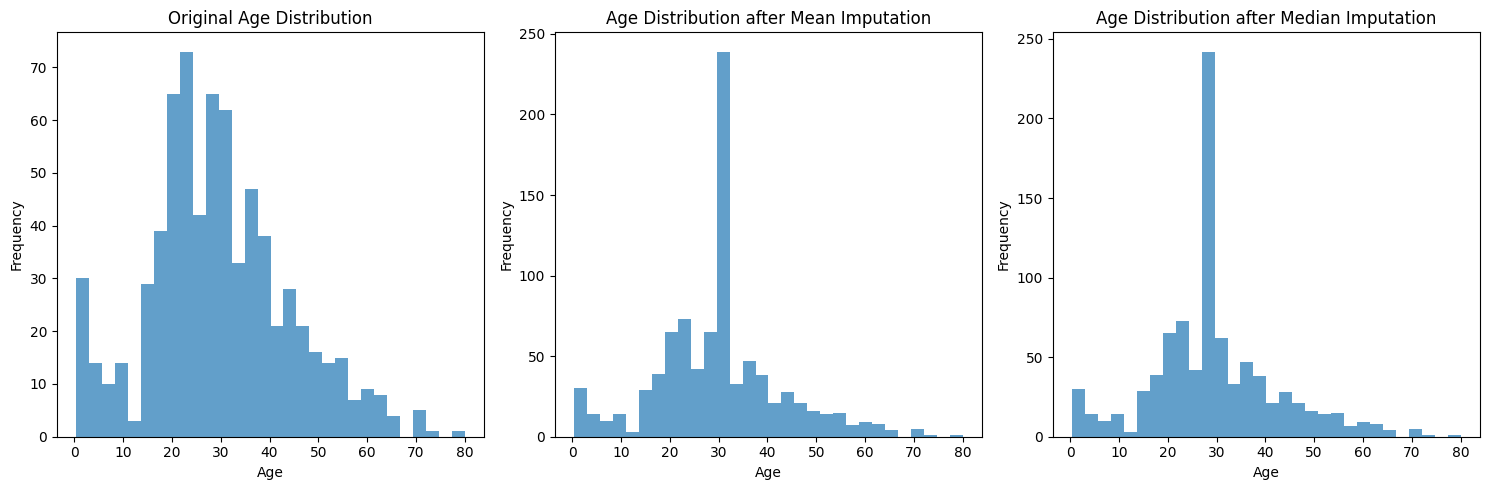

Observation: Compare the histograms. Median imputation often preserves the shape of the distribution better, especially if there are outliers.


In [18]:
# Exercise 2 - Part 1: Mean vs Median Imputation for Age

# Create copies to compare
df_age_mean = df.copy()
df_age_median = df.copy()

# Impute with mean
mean_age = df_age_mean['Age'].mean()
df_age_mean['Age'] = df_age_mean['Age'].fillna(mean_age)

# Impute with median
median_age = df_age_median['Age'].median()
df_age_median['Age'] = df_age_median['Age'].fillna(median_age)

# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df['Age'].dropna(), bins=30, alpha=0.7)
axes[0].set_title('Original Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_age_mean['Age'], bins=30, alpha=0.7)
axes[1].set_title('Age Distribution after Mean Imputation')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

axes[2].hist(df_age_median['Age'], bins=30, alpha=0.7)
axes[2].set_title('Age Distribution after Median Imputation')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Observation: Compare the histograms. Median imputation often preserves the shape of the distribution better, especially if there are outliers.")

In [20]:
# Exercise 2 - Part 2: Embarked Imputation (Unknown vs Mode)

# Original value counts (excluding NA)
print("Original Embarked value counts (excluding NA):")
print(df['Embarked'].value_counts(dropna=True))

# Impute with 'Unknown'
df_embarked_unknown = df.copy()
df_embarked_unknown['Embarked'] = df_embarked_unknown['Embarked'].fillna('Unknown')
print("\nEmbarked value counts after filling with 'Unknown':")
print(df_embarked_unknown['Embarked'].value_counts(dropna=False)) # include counts of 'Unknown'

# Impute with mode
df_embarked_mode = df.copy()
mode_embarked = df_embarked_mode['Embarked'].mode()[0]
df_embarked_mode['Embarked'] = df_embarked_mode['Embarked'].fillna(mode_embarked)
print("\nEmbarked value counts after filling with Mode:")
print(df_embarked_mode['Embarked'].value_counts(dropna=False)) # should not have NA

print("\nObservation: Filling with 'Unknown' creates a new category, while filling with the mode increases the count of the most frequent category.")

Original Embarked value counts (excluding NA):
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Embarked value counts after filling with 'Unknown':
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64

Embarked value counts after filling with Mode:
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

Observation: Filling with 'Unknown' creates a new category, while filling with the mode increases the count of the most frequent category.


## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

In [ ]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

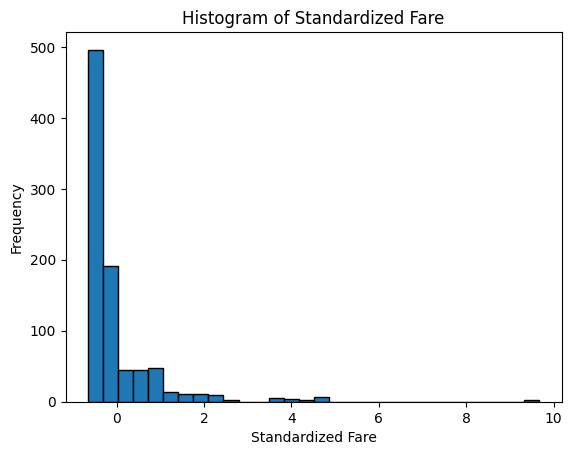

In [21]:
scaler = StandardScaler()
df['Fare_Standardized'] = scaler.fit_transform(df[['Fare']])

plt.hist(df['Fare_Standardized'], bins=30, edgecolor='black')
plt.title("Histogram of Standardized Fare")
plt.xlabel("Standardized Fare")
plt.ylabel("Frequency")
plt.show()

In [22]:
normalizer = Normalizer()
normalized_data = normalizer.fit_transform(df[['Age', 'Fare']].fillna(0))  # handle NaN with fillna(0)

# Convert to DataFrame for easier viewing
normalized_df = pd.DataFrame(normalized_data, columns=['Age_Normalized', 'Fare_Normalized'])

# Show first 5 normalized vectors
print(normalized_df.head())

   Age_Normalized  Fare_Normalized
0        0.949757         0.312988
1        0.470417         0.882444
2        0.956551         0.291564
3        0.550338         0.834942
4        0.974555         0.224148


## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [ ]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

In [ ]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

In [26]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
df['Embarked'] = df['Embarked'].fillna('Missing')

# --- Ordinal Encoding ---
ordinal_encoder = OrdinalEncoder()
embarked_ordinal = ordinal_encoder.fit_transform(df[['Embarked']])

print("Unique categories in 'Embarked':", ordinal_encoder.categories_)
print("Number of features after Ordinal Encoding:", embarked_ordinal.shape[1])  # always 1 column

# --- One-Hot Encoding ---
onehot_encoder = OneHotEncoder(sparse_output=False)
embarked_onehot = onehot_encoder.fit_transform(df[['Embarked']])

print("Number of features after One-Hot Encoding:", embarked_onehot.shape[1])
print("One-Hot feature names:", onehot_encoder.get_feature_names_out(['Embarked']))

Unique categories in 'Embarked': [array(['C', 'Missing', 'Q', 'S'], dtype=object)]
Number of features after Ordinal Encoding: 1
Number of features after One-Hot Encoding: 4
One-Hot feature names: ['Embarked_C' 'Embarked_Missing' 'Embarked_Q' 'Embarked_S']


## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

In [ ]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

In [ ]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [ ]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

Skewness of Fare: 4.787316519674893


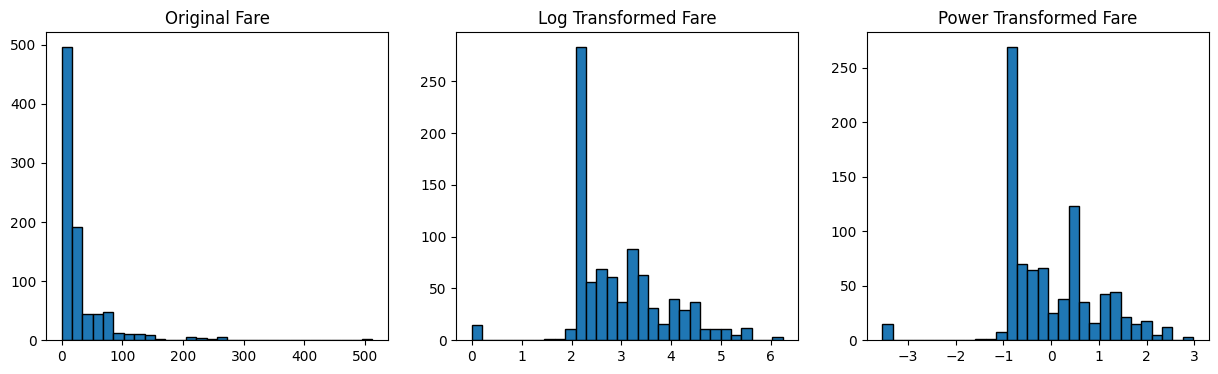

In [27]:
skew_value = df['Fare'].skew()
print("Skewness of Fare:", skew_value)

# --- Log Transform ---
df['Fare_Log'] = np.log1p(df['Fare'])  # log(1+Fare) to handle zeros

# --- Power Transform (Yeo-Johnson) ---
pt = PowerTransformer(method='yeo-johnson')
df['Fare_Power'] = pt.fit_transform(df[['Fare']])

# --- Compare Histograms ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(df['Fare'], bins=30, edgecolor='black')
axes[0].set_title("Original Fare")

axes[1].hist(df['Fare_Log'], bins=30, edgecolor='black')
axes[1].set_title("Log Transformed Fare")

axes[2].hist(df['Fare_Power'], bins=30, edgecolor='black')
axes[2].set_title("Power Transformed Fare")

plt.show()

In [28]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['Age', 'Fare']].fillna(0))

# Feature names
feature_names = poly.get_feature_names_out(['Age', 'Fare'])
print("Polynomial Feature Names (degree=2):", feature_names)

# Show first 5 rows
poly_df = pd.DataFrame(poly_features, columns=feature_names)
print(poly_df.head())

Polynomial Feature Names (degree=2): ['Age' 'Fare' 'Age^2' 'Age Fare' 'Fare^2']
    Age     Fare   Age^2   Age Fare       Fare^2
0  22.0   7.2500   484.0   159.5000    52.562500
1  38.0  71.2833  1444.0  2708.7654  5081.308859
2  26.0   7.9250   676.0   206.0500    62.805625
3  35.0  53.1000  1225.0  1858.5000  2819.610000
4  35.0   8.0500  1225.0   281.7500    64.802500


## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

In [ ]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [29]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])  # select numeric cols
variance = numeric_df.var().sort_values(ascending=False)
print("Variance of numeric columns:\n", variance)

top2 = variance.head(2)
print("\nTop 2 columns with highest variance:\n", top2)

Variance of numeric columns:
 PassengerId          66231.000000
Fare                  2469.436846
Age                    211.019125
SibSp                    1.216043
Fare_Standardized        1.001124
Fare_Power               1.001124
Fare_Log                 0.939055
Pclass                   0.699015
Parch                    0.649728
Survived                 0.236772
dtype: float64

Top 2 columns with highest variance:
 PassengerId    66231.000000
Fare            2469.436846
dtype: float64


In [30]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df.fillna(0))

pca = PCA(n_components=3)
pca.fit(scaled_data)

print("\nExplained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())


Explained variance ratio: [0.43427149 0.15924729 0.10024547]
Cumulative explained variance: [0.43427149 0.59351878 0.69376426]


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

In [31]:
df['Age'] = df['Age'].fillna(df['Age'].median())       # Median imputation for Age
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])  # Mode for Embarked
df['Cabin'] = df['Cabin'].fillna('Unknown')

In [32]:
scaler_std = StandardScaler()
df['Age_Std'] = scaler_std.fit_transform(df[['Age']])

scaler_mm = MinMaxScaler()
df['Fare_MinMax'] = scaler_mm.fit_transform(df[['Fare']])

In [ ]:
encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' to avoid dummy trap
encoded = encoder.fit_transform(df[['Sex', 'Embarked']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Sex', 'Embarked']))

In [ ]:
df['Fare_Log'] = np.log1p(df['Fare'])  # log1p to handle zero fares

# --- Combine ---
processed = pd.concat([df, encoded_df], axis=1)

In [ ]:
numeric_cols = ['Age_Std', 'Fare_MinMax', 'Fare_Log']
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed[numeric_cols])
processed['PCA1'] = pca_result[:,0]
processed['PCA2'] = pca_result[:,1]

## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).